# Advanced Lane Finding Project
The goals of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


First, we cover these steps and show the results:

* Camera calibration
* Distortion correction
* Color/gradient threshold
* Perspective transform

After doing those steps, we will do these steps and show the results:

* Detect lane lines
* Determine the lane curvature

Finally, we put all the stemps together and show the results for one image. Then, the result for a video is illustrated

## Camera Calibration

In this part, there are 20 chessboard images and camera calibration is done on these images to obtain nessecary parameters for the next steps. Three of the images are not shown since the whole chessboard is not in the image and some of corners are missing.

number of images for calibration:  20
./camera_cal/calibration10.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration6.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration9.jpg


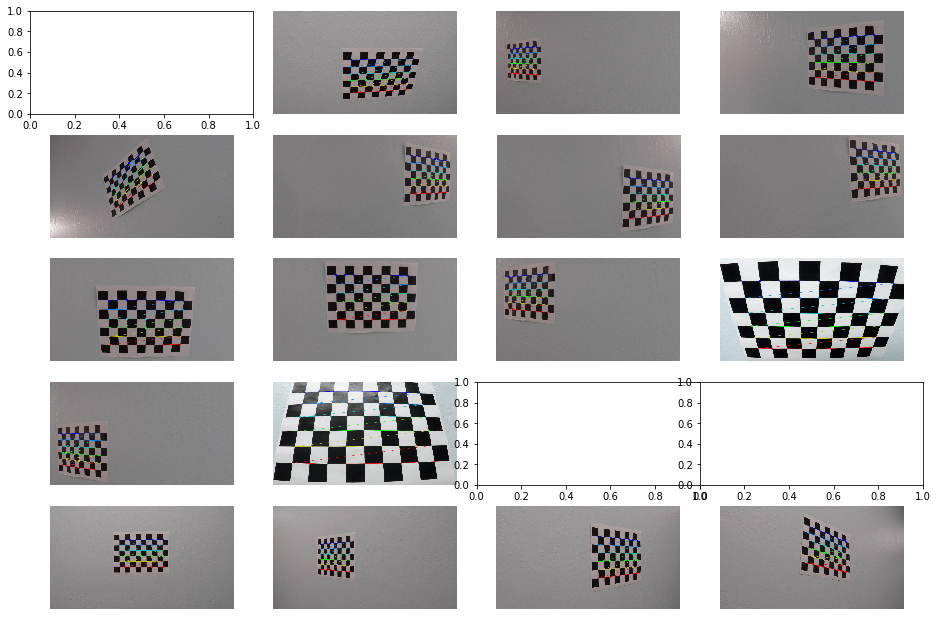

In [1]:
# Camera Calibration

import glob
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

def cameraCalibration():
    fig, axs = plt.subplots(5,4, figsize=(16, 11))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    directory = './output_images'
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('./camera_cal/calibration*.jpg')
    print("number of images for calibration: " , len(images))
    count = 0
    # Step through the list and search for chessboard corners
    for fname in images:

        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            print(fname)
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            corner_img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            cv2.imwrite(directory + '/display_corners_'+ fname[13:] ,corner_img)
            #cv2.waitKey(500)
            axs[count].axis('off')
            axs[count].imshow(corner_img)
        count +=1
    return objpoints, imgpoints
    #cv2.destroyAllWindows()
objpoints, imgpoints = cameraCalibration()
   

## Defining Functions
Here, we define several functions for undistortion, thresholding, warped and selecting regin of interest.

In [2]:
# a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def undistort_img(img,mtx,dist):
    #print(ret, mtx, dist)
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

In [15]:
def combine_thresholds(img):
    
    # convert to gray scale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h,w = gray.shape
    
    # apply x gradient threshold and dir graadient threshold
    sx_binary = abs_sobel_thresh(gray, 'x', 10, 200)
    dir_binary = dir_threshold(gray, thresh=(np.pi/6, np.pi/2))
    
    # combine the gradient and direction thresholds.
    gradients_combined = ((sx_binary == 1) & (dir_binary == 1))
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 150
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    rg_combined = (R > color_threshold) & (G > color_threshold)
    
    
    # color channel thresholds
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    l = hls[:,:,1]
    
    # S channel performs well for detecting bright yellow and white lanes
    s_thresh = (100, 255)
    s_condition = (s > s_thresh[0]) & (s <= s_thresh[1])

    l_thresh = (120, 255)
    l_condition = (l > l_thresh[0]) & (l <= l_thresh[1])

    # combine all the thresholds
    color_combined[(rg_combined & l_condition) & 
                   (s_condition | gradients_combined)] = 1
    
    # apply the region of interest mask
    mask = np.zeros_like(color_combined)
    region_of_interest_vertices = np.array([[0,h-1], [w/2, int(0.5*h)],
                                            [w-1, h-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    thresholded = cv2.bitwise_and(color_combined, mask)
    
    return thresholded
    
    
    
def abs_sobel_thresh(gray, orient='x', thresh_min=0, thresh_max=255):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobel)
    max_value = np.max(abs_sobel)
    binary_output = np.uint8(255*abs_sobel/max_value)
    threshold_mask = np.zeros_like(binary_output)
    threshold_mask[(binary_output >= thresh_min) & (binary_output <= thresh_max)] = 1
    return threshold_mask

def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    direction = np.arctan2(abs_sobel_y,abs_sobel_x)
    direction = np.absolute(direction)
    # 5) Create a binary mask where direction thresholds are met
    mask = np.zeros_like(direction)
    mask[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return mask

In [16]:
def warped(gray,src_points,dst_points):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    Minv = cv2.getPerspectiveTransform(dst_points,src_points)
    warped = cv2.warpPerspective(gray, M, (gray.shape[1],gray.shape[0]), 
                                 flags=cv2.INTER_LINEAR)        
    return warped, Minv

In [17]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending 
    #on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


## Undistort and Unwarp chessboard images
In this section, we use defined functions to undistort chessboard images. 

In [18]:
# This function performs camera calibration once on all chessboard images once
# Then perform undistortion on chessboard images
# After that, unwarp undistorted images and save them all
def undistort_unwarp_chessboard_images():   
    fig, axs = plt.subplots(5,4, figsize=(16, 11))
    fig.subplots_adjust(hspace = .2, wspace=.001)
    axs = axs.ravel()
  
    #objpoints, imgpoints  = cameraCalibration()
    directory = './output_images'
    images = glob.glob('./camera_cal/calibration*.jpg')
    nx = 9
    ny = 6
    count = 0
    flag = 'True'
    for fname in images:
        #print(fname)
        
        img = cv2.imread(fname)
        if flag == 'True':
            ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,
                                                               imgpoints,
                                                               img.shape[:2],
                                                               None, None)
            flag = 'False'
        undistorted_image = undistort_img(img,mtx,dist)
        cv2.imwrite(directory + '/undistorted_'+ fname[13:] ,undistorted_image)
        gray = cv2.cvtColor(undistorted_image,cv2.COLOR_BGR2GRAY)
        img_size = (gray.shape[1],gray.shape[0])
        
  
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        if ret:
            src_points = np.float32([ corners[0], corners[nx-1], corners[-1], 
                                     corners[-nx]])
            offset = 100
            dst_points = np.float32([[offset, offset], 
                                     [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
            warped_binary, Minv = warped(gray,src_points,dst_points)
            cv2.imwrite(directory + '/warped_'+ fname[13:] ,warped_binary)
            axs[count].axis('off')
            axs[count].imshow( warped_binary,cmap ='Greys')
        count +=1
            #combined_binary = combine_thresholds(gray)
            #cv2.imwrite(directory + '/combined_binary_'+ fname[13:] ,combined_binary)

In [19]:
#undistort_unwarp_chessboard_images()

## Test Image
We show results for one test image. The captions below each image is about the process. 

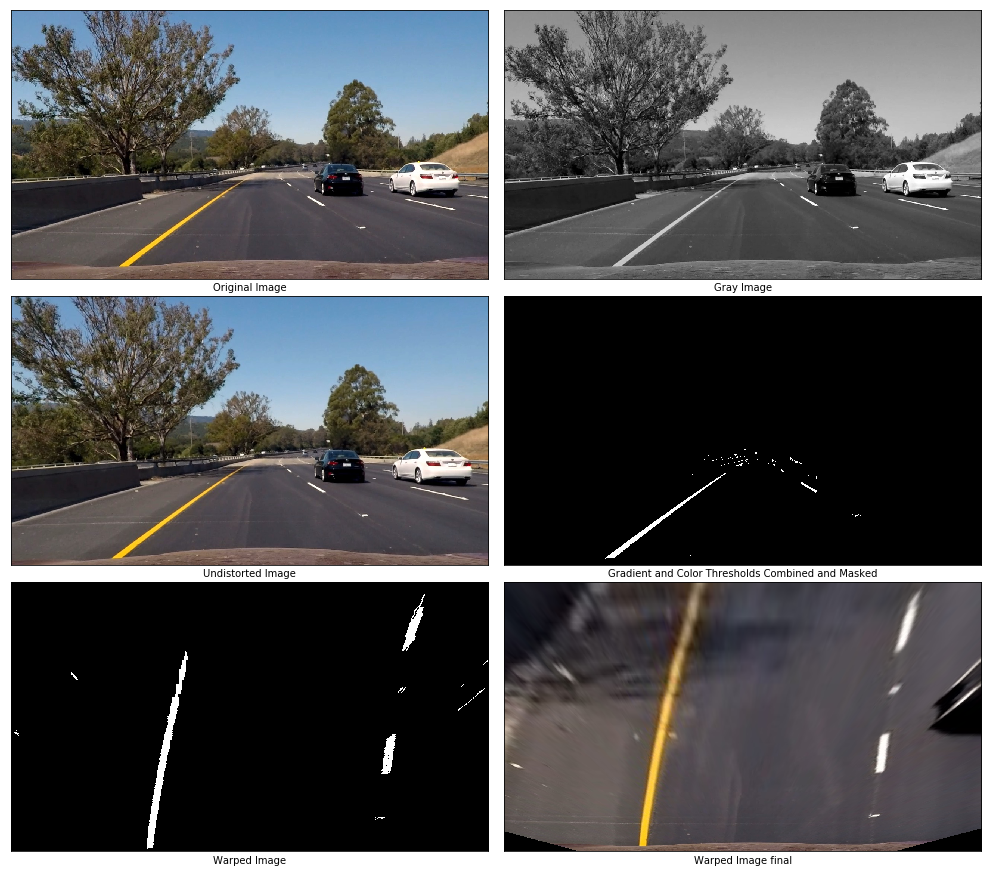

In [20]:
fname = './test_images/' + 'test6.jpg'
#img = cv2.imread(fname)
#img = mpimg.imread('./test_images/straight_lines1.jpg')
img = mpimg.imread(fname)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, 
                                                   img.shape[:2], None, None)
test_image = plt.figure(figsize=(14,16))

axis = test_image.add_subplot(4,2,1)
axis.set_xlabel("Original Image")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
axis.imshow(img)

axis = test_image.add_subplot(4,2,2)
axis.set_xlabel("Gray Image")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
axis.imshow(gray,cmap='gray')

axis = test_image.add_subplot(4,2,3)
axis.set_xlabel("Undistorted Image")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
undistorted_image = undistort_img(img,mtx,dist)
axis.imshow(undistorted_image)


axis = test_image.add_subplot(4,2,4)
axis.set_xlabel("Gradient and Color Thresholds Combined and Masked")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
gradient_thresh_binary = combine_thresholds(undistorted_image)
axis.imshow(gradient_thresh_binary,cmap ='gray')

axis = test_image.add_subplot(4,2,5)
axis.set_xlabel("Warped Image")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
src_points = np.float32([[180, img.shape[0]], [575, 460], 
                  [705, 460], [1150, img.shape[0]]])
# Define 4 destination points
dst_points = np.float32([[320, img.shape[0]], [320, 0], 
                  [960, 0], [960, img.shape[0]]])
 
warped_binary,Minv = warped(gradient_thresh_binary,src_points,dst_points)
axis.imshow(warped_binary,cmap ='gray')


axis = test_image.add_subplot(4,2,6)
axis.set_xlabel("Warped Image final")
plt.xticks(np.array([]))
plt.yticks(np.array([]))
warped_img,Minv = warped(img,src_points,dst_points)
axis.imshow(warped_img)


test_image.tight_layout(h_pad=0, w_pad=0)

In [21]:
# Define a class to receive the characteristics of each line detection
import collections
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(12*[0.0, 0.0, 0.0], 12)
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

## Finding Lanes
Here, we perform finding_lanes function to find left and right lanes. the results are visualized for windows search and lane detection. 

In [22]:
# Implement Sliding Windows and Fit a Polynomial
def finding_lanes(binary_warped):
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Assuming you have created a warped binary image called "binary_warped"
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 60
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    if (left_line_obj.detected == False) or (right_line_obj.detected == False):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # Create an output image to draw on and  visualize the result

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
           # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on 
            #their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        left_line_obj.detected = True
        right_line_obj.detected = True

    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        left_lane_inds = ((nonzerox > (left_line_obj.current_fit[0]*(nonzeroy**2) + 
                                       left_line_obj.current_fit[1]*nonzeroy + 
                                       left_line_obj.current_fit[2] - margin)) & 
                          (nonzerox < (left_line_obj.current_fit[0]*(nonzeroy**2) + 
                                       left_line_obj.current_fit[1]*nonzeroy + 
                                       left_line_obj.current_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_line_obj.current_fit[0]*(nonzeroy**2) + 
                                        right_line_obj.current_fit[1]*nonzeroy + 
                                        right_line_obj.current_fit[2] - margin)) & 
                           (nonzerox < (right_line_obj.current_fit[0]*(nonzeroy**2) + 
                                        right_line_obj.current_fit[1]*nonzeroy + 
                                        right_line_obj.current_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    if (len(leftx) < 1600):
        leftx = left_line_obj.allx
        lefty = left_line_obj.ally
        left_line_obj.detected = False
    else:
        left_line_obj.allx = leftx
        left_line_obj.ally = lefty
    if (len(rightx) < 1600):
        rightx = right_line_obj.allx
        righty = right_line_obj.ally
        right_line_obj.detected = False
    else:
        right_line_obj.allx = rightx
        right_line_obj.ally = righty

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #check distanse and cu
    if (left_line_obj.current_fit[0] == False):
        left_line_obj.current_fit = left_fit
        right_line_obj.current_fit = right_fit
        
    if (abs(left_line_obj.current_fit[1] - left_fit[1]) > 0.2):
        left_line_obj.current_fit = left_line_obj.best_fit
        left_line_obj.detected = False
    else:
        left_line_obj.current_fit = left_fit
        left_line_obj.recent_xfitted.pop()
        left_line_obj.recent_xfitted.appendleft(left_line_obj.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_line_obj.recent_xfitted:
            avg = avg + element
        left_line_obj.best_fit = avg / (len(left_line_obj.recent_xfitted))
        
    if (abs(right_line_obj.current_fit[1] - right_fit[1]) > 0.2):
        right_line_obj.current_fit = right_line_obj.best_fit
        right_line_obj.detected = False
    else:
        right_line_obj.current_fit = right_fit
        right_line_obj.recent_xfitted.pop()
        right_line_obj.recent_xfitted.appendleft(right_line_obj.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_line_obj.recent_xfitted:
            avg = avg + element
        right_line_obj.best_fit = avg / (len(right_line_obj.recent_xfitted))
        
    if (abs(right_line_obj.current_fit[1] - right_fit[1]) > 0.4 and
        abs(left_line_obj.current_fit[1] - left_fit[1]) < 0.1):
        right_line_obj.current_fit[0] = left_line_obj.current_fit[0]
        right_line_obj.current_fit[1] = left_line_obj.current_fit[1]
        right_line_obj.current_fit[2] = left_line_obj.current_fit[2] + 600
        right_line_obj.recent_xfitted.pop()
        right_line_obj.recent_xfitted.appendleft(right_line_obj.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_line_obj.recent_xfitted:
            avg = avg + element
        right_line_obj.best_fit = avg / (len(right_line_obj.recent_xfitted))
        
    if (abs(left_line_obj.current_fit[1] - left_fit[1]) > 0.4 and
        abs(right_line_obj.current_fit[1] - right_fit[1]) < 0.1):
        left_line_obj.current_fit = left_fit
        left_line_obj.recent_xfitted.pop()
        left_line_obj.recent_xfitted.appendleft(left_line_obj.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_line_obj.recent_xfitted:
            avg = avg + element
        left_line_obj.best_fit = avg / (len(left_line_obj.recent_xfitted))

    return left_fit, right_fit,out_img, leftx, lefty, rightx, righty
    

In [23]:
def visualization_slidingWindow(binary_warped,left_fit,right_fit,leftx, lefty, \
                                rightx, righty, out_img):
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

In [24]:
def visualization_Lanes(binary_warped, leftx, lefty, rightx, righty):
    # Set the width of the windows +/- margin
    margin = 100
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    #plt.xlim(0, 1280)
    #plt.ylim(720, 0)

In [25]:
def curveture_offset(binary_warped, left_fit, right_fit, leftx, lefty, rightx, righty):
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + 
                           left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + 
                            right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    if len(leftx) != 0 and len(rightx) != 0:
        #print('here', len(leftx), len(lefty))
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + 
                               left_fit_cr[1])**2)**1.5) / \
        np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + 
                                right_fit_cr[1])**2)**1.5) / \
        np.absolute(2*right_fit_cr[0])
    
    curverad = np.mean([left_curverad, right_curverad])
    
    image_centre = 1280/2 * xm_per_pix
    
    offset = 0
    if left_fit is not None and right_fit is not None:
        left_lane_bottom = (left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                            left_fit_cr[1] * (y_eval * ym_per_pix) + left_fit_cr[2])

        right_lane_bottom = (right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                             right_fit_cr[1] * (y_eval * ym_per_pix) + right_fit_cr[2])

        centre = float(right_lane_bottom + left_lane_bottom) / 2
        offset = (image_centre - centre)
        
    #print('Offset from Center: ', offset, ' m')
    return curverad, offset

In [26]:
# Create an image to draw the lines on
def draw_lines_offset(warped_binary,left_fit, right_fit,Minv,undist,curverad, offset,
                      plot_flag='True'):
    
    ploty = np.linspace(0, warped_binary.shape[0]-1, warped_binary.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    warp_zero = np.zeros_like(warped_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, 
                                  (color_warp.shape[1], color_warp.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    cv2.putText(result, 'Curvature Rad: {} m'.format(int(curverad)), (120,140),
             fontFace = 16, fontScale = 1.5, color=(0,0,255), thickness = 6)
    cv2.putText(result, "Offset: {:.2f} m".format(float(offset)), (120,240),
             fontFace = 16, fontScale = 1.5, color=(0,0,255), thickness = 6)
    
    if plot_flag == 'True':
        plt.imshow(result)
    else:
        return result

Lane detection results for test image are shown here. 

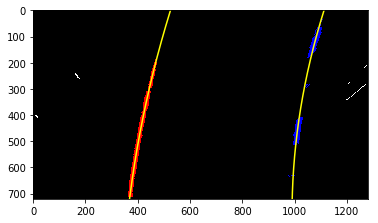

In [27]:
left_line_obj = Line()
right_line_obj = Line()
left_fit, right_fit, out_img,leftx, lefty, rightx,righty = finding_lanes(warped_binary)
curverad, offset = curveture_offset(warped_binary, left_fit, right_fit, \
                                    leftx, lefty, rightx, righty)

visualization_slidingWindow(warped_binary,left_fit,right_fit,leftx, lefty, \
                            rightx, righty, out_img)

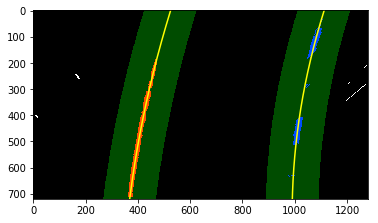

In [28]:
visualization_Lanes(warped_binary,leftx, lefty, rightx, righty)

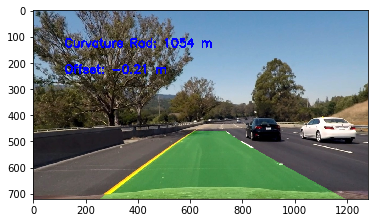

In [29]:
draw_lines_offset(warped_binary,left_fit, right_fit,Minv,
                  undistorted_image,curverad,offset,plot_flag='True')

This is the pipleline for detecting lane on road images. 

In [30]:
def advance_line_detection_pipeline(image,plot_flag = 'False'):
    
    undistorted_img = undistort_img(image,mtx,dist)
    gradient_thresh_binary = combine_thresholds(undistorted_img)
    src_points = np.float32([[180, image.shape[0]], [575, 460], 
                  [705, 460], [1150, image.shape[0]]])
    # Define 4 destination points
    dst_points = np.float32([[320, image.shape[0]], [320, 0], 
                  [960, 0], [960, image.shape[0]]])
    warped_binary,Minv = warped(gradient_thresh_binary,src_points,dst_points)
    left_fit, right_fit, out_img,leftx, lefty, rightx, \
    righty = finding_lanes(warped_binary)
    curverad, offset = curveture_offset(warped_binary, left_fit, right_fit,\
                                        leftx, lefty, rightx, righty)
    output = draw_lines_offset(warped_binary,left_fit, right_fit,Minv,
                               undistorted_img,curverad,offset,plot_flag)
    return output

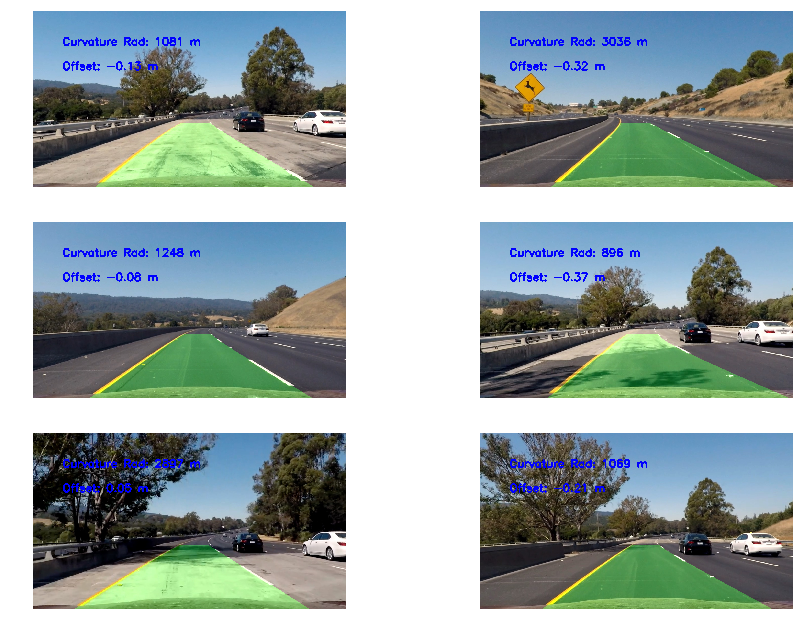

In [31]:
fig, axs = plt.subplots(3,2, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()


fname = './test_images/' + 'test1.jpg'
#img = cv2.imread(fname)
img = mpimg.imread(fname)
output = advance_line_detection_pipeline(img, 'False')
axs[0].axis('off')
axs[0].imshow(output)

fname = './test_images/' + 'test2.jpg'
#img = cv2.imread(fname)
img = mpimg.imread(fname)
output = advance_line_detection_pipeline(img, 'False')
axs[1].axis('off')
axs[1].imshow(output)

fname = './test_images/' + 'test3.jpg'
#img = cv2.imread(fname)
img = mpimg.imread(fname)
output = advance_line_detection_pipeline(img, 'False')
axs[2].axis('off')
axs[2].imshow(output)

fname = './test_images/' + 'test4.jpg'
#img = cv2.imread(fname)
img = mpimg.imread(fname)
output = advance_line_detection_pipeline(img, 'False')
axs[3].axis('off')
axs[3].imshow(output)

fname = './test_images/' + 'test5.jpg'
#img = cv2.imread(fname)
img = mpimg.imread(fname)
output = advance_line_detection_pipeline(img, 'False')
axs[4].axis('off')
axs[4].imshow(output)

fname = './test_images/' + 'test6.jpg'
#img = cv2.imread(fname)
img = mpimg.imread(fname)
output = advance_line_detection_pipeline(img, 'False')
axs[5].axis('off')
axs[5].imshow(output)

## Test on Video

In this last part, we test the pipeline on one video and represent the result.

In [34]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os
left_line_obj = Line()
right_line_obj = Line()
white_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter 
#subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and 
#end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")#.subclip(30,45)
white_clip = clip1.fl_image(advance_line_detection_pipeline) 
#NOTE: this function  expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:01<00:00,  4.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 5min 8s, sys: 59.5 s, total: 6min 8s
Wall time: 4min 2s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))